In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
import tensorflow
print (tensorflow.__version__)

2.4.1


Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


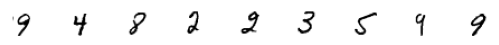

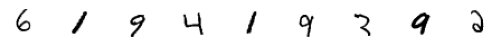

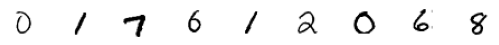

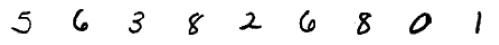

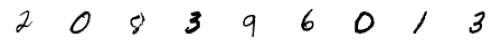

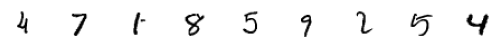

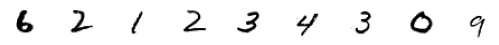

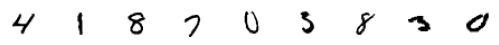

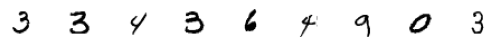

In [4]:
from tensorflow.keras.datasets import fashion_mnist, mnist

(trainX, trainY), (testX, testY) = mnist.load_data()

print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testY.shape))

for k in range(9):
    plt.figure(figsize=(9, 6))
    for j in range(9):
        i = np.random.randint(0, 10000)
        plt.subplot(990 + 1 + j)
        plt.imshow(trainX[i], cmap='gray_r')
        #plt.title(trainY[i])
        plt.axis('off')
    plt.show()

In [5]:
#Ten classes
set(trainY)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [6]:
trainX = [(image-127.5)/127.5 for image in trainX]
testX = [(image-127.5)/127.5 for image in testX]

trainX = np.reshape(trainX, (60000, 28, 28, 1))
testX = np.reshape(testX, (10000, 28, 28, 1))

print (trainX.shape, testX.shape, trainY.shape, testY.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1) (60000,) (10000,)


# Generator Model

In [8]:
random_input = tensorflow.keras.layers.Input(shape = 50)
control_input = tensorflow.keras.layers.Input(shape = 10)

x1 = tensorflow.keras.layers.Dense(64)(random_input)

#Class Input
x2 = tensorflow.keras.layers.Dense(32)(control_input)

x = tensorflow.keras.layers.Concatenate()([x1, x2])

x = tensorflow.keras.layers.Dense(5*5*64)(x)
x = tensorflow.keras.layers.Activation('relu')(x)

x = tensorflow.keras.layers.Reshape((5, 5, 64))(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3,3), strides=2)(x)
x = tensorflow.keras.layers.Activation('relu')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3,3), strides=2)(x)
x = tensorflow.keras.layers.Activation('relu')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3,3))(x)
x = tensorflow.keras.layers.Activation('relu')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=1, kernel_size=(4,4))(x)
generated_image = tensorflow.keras.layers.Activation('tanh')(x)

generator_network = tensorflow.keras.models.Model(inputs=[random_input, control_input], outputs=generated_image)
generator_network.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           3264        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           352         input_2[0][0]                    
______________________________________________________________________________________________

# Discriminator

In [12]:
image_input = tensorflow.keras.layers.Input(shape=(28, 28, 1))

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=2)(image_input)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=2)(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(3,3))(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(4,4))(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

features = tensorflow.keras.layers.Flatten()(x)

d_out = tensorflow.keras.layers.Dense(1)(features)
real_vs_fake_output = tensorflow.keras.layers.Activation('sigmoid')(d_out)

discriminator_network = tensorflow.keras.models.Model(inputs=image_input, outputs=real_vs_fake_output)

info = tensorflow.keras.layers.Dense(10)(features)
info_output = tensorflow.keras.layers.Activation('softmax')(info)

info_network = tensorflow.keras.models.Model(inputs=image_input, outputs=info_output)

print (discriminator_network.summary())
print (info_network.summary())

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 13, 13, 128)       1280      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 6, 6, 128)         147584    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 6, 6, 128)         0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 6, 6, 128)         512       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 4, 128)         1475

In [13]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
discriminator_network.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

info_network.compile(loss='categorical_crossentropy', optimizer=adam_optimizer)

# GAN

In [14]:
discriminator_network.trainable=False

g_output = generator_network([random_input, control_input])

d_output = discriminator_network(g_output)
info_output = info_network(g_output)

info_gan_model = tensorflow.keras.models.Model(inputs = [random_input, control_input], outputs=[d_output, info_output])
info_gan_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 28, 28, 1)    531425      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
model_7 (Functional)            (None, 1)            428929      model[0][0]                

# Compiling InfoGAN

In [18]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
info_gan_model.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer=adam_optimizer)

# Define Data Generators

In [19]:
indices = [i for i in range(0, len(trainX))]

def encode_control_input(value):
    x = np.zeros((10))
    x[value]=1
    return x

def decode_control_input(value):
    return np.where(value==1)[0][0]

def get_random_noise(batch_size, noise_size):
    random_values = np.random.randn(batch_size*noise_size)
    random_noise_batches = np.reshape(random_values, (batch_size, noise_size))
    control_inputs = []
    for i in range(batch_size):
        control_input = np.random.choice([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], size=1)
        control_inputs.append(encode_control_input(control_input))
    control_inputs = np.array(control_inputs)
    return random_noise_batches, control_inputs

def get_fake_samples(generator_network, batch_size, noise_size):
    random_noise_batches, control_inputs= get_random_noise(batch_size, noise_size) 
    fake_samples = generator_network.predict_on_batch([random_noise_batches, control_inputs])
    return fake_samples

def get_real_samples(batch_size):
    random_indices = np.random.choice(indices, size=batch_size)
    real_images = trainX[np.array(random_indices),:]
    return real_images

def show_generator_results(generator_network):
    for k in range(10):
        random_noise_batches, _ = get_random_noise(10, noise_size) 
        control_inputs = []
        for bs in range(10):
            control_inputs.append(encode_control_input(k))
        control_inputs = np.array(control_inputs)
        fake_samples = generator_network.predict_on_batch([random_noise_batches, control_inputs])
        plt.figure(figsize=(9, 6))
        for j in range(9):
            i = j
            plt.subplot(990 + 1 + j)
            plt.imshow(fake_samples[i,:,:,-1], cmap='gray_r')
            #plt.title(decode_control_input(control_inputs[i]))
            plt.axis('off')
        plt.show()
    return

# Training GAN

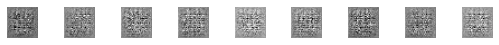

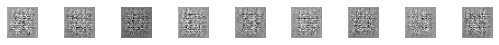

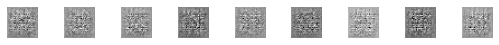

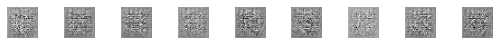

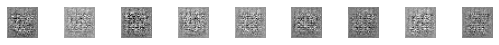

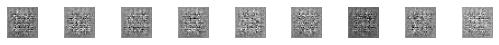

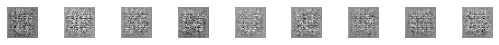

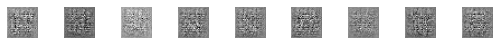

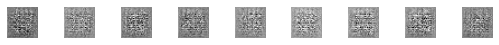

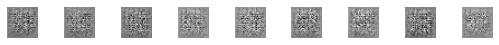

Epoch:0, Step:0, D-Loss:1.389, D-Acc:10.000, G-Loss:2.999, Info-Loss:0.684
Epoch:0, Step:50, D-Loss:0.079, D-Acc:97.000, G-Loss:6.304, Info-Loss:3.760
Epoch:0, Step:100, D-Loss:0.147, D-Acc:93.000, G-Loss:7.117, Info-Loss:4.507
Epoch:0, Step:150, D-Loss:0.052, D-Acc:99.000, G-Loss:7.862, Info-Loss:5.318
Epoch:0, Step:200, D-Loss:0.088, D-Acc:96.000, G-Loss:8.136, Info-Loss:5.443
Epoch:0, Step:250, D-Loss:0.130, D-Acc:94.000, G-Loss:7.268, Info-Loss:4.967
Epoch:0, Step:300, D-Loss:0.095, D-Acc:96.000, G-Loss:8.229, Info-Loss:5.858
Epoch:0, Step:350, D-Loss:0.159, D-Acc:94.000, G-Loss:6.439, Info-Loss:4.223
Epoch:0, Step:400, D-Loss:0.088, D-Acc:97.000, G-Loss:6.769, Info-Loss:4.659
Epoch:0, Step:450, D-Loss:0.117, D-Acc:95.000, G-Loss:6.056, Info-Loss:3.898
Epoch:1, Step:0, D-Loss:0.083, D-Acc:98.000, G-Loss:6.766, Info-Loss:4.861
Epoch:1, Step:50, D-Loss:0.201, D-Acc:89.000, G-Loss:5.915, Info-Loss:3.985
Epoch:1, Step:100, D-Loss:0.184, D-Acc:93.000, G-Loss:5.747, Info-Loss:4.000
Epoch

In [ ]:
epochs = 500
batch_size = 100
steps = 500
noise_size = 50

for i in range(0, epochs):
    if (i%5 == 0):
        op = show_generator_results(generator_network)
        #print (op)
    for j in range(steps):
        fake_samples = get_fake_samples(generator_network, batch_size//2, noise_size)
        real_samples = get_real_samples(batch_size=batch_size//2)

        fake_y = np.zeros((batch_size//2, 1))
        real_y = np.ones((batch_size//2, 1))
        
        input_samples = np.vstack((fake_samples, real_samples))
        output_labels = np.vstack((fake_y, real_y))
        
        # Updating Discriminator weights
        discriminator_network.trainable=True
        loss_d = discriminator_network.train_on_batch(input_samples, output_labels)
        
        noise_batches, control_inputs = get_random_noise(batch_size, noise_size)
        info_gan_input = [noise_batches, control_inputs]
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        d_output = np.ones((batch_size))
        info_output = control_inputs
        info_gan_output = [d_output, info_output]
        
        # Updating Generator weights
        discriminator_network.trainable=False
        loss_g = info_gan_model.train_on_batch(info_gan_input, info_gan_output)
        
        if j%50 == 0:
            print ("Epoch:%.0f, Step:%.0f, D-Loss:%.3f, D-Acc:%.3f, G-Loss:%.3f, Info-Loss:%.3f"%(i,j,loss_d[0],loss_d[1]*100,loss_g[0], loss_g[1]))
            

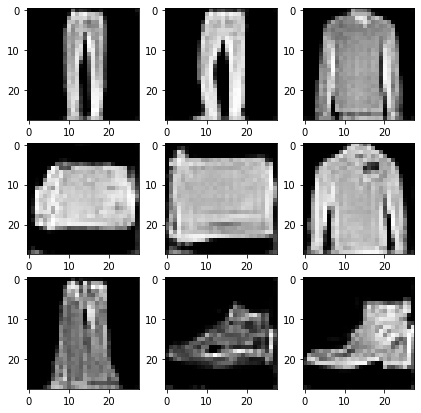

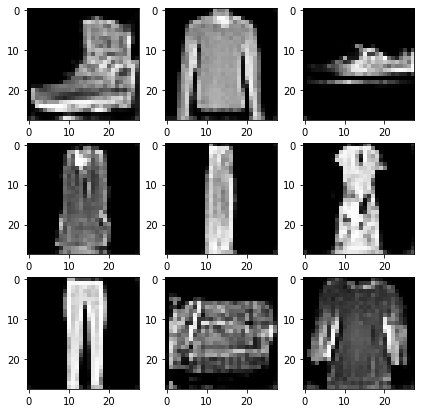

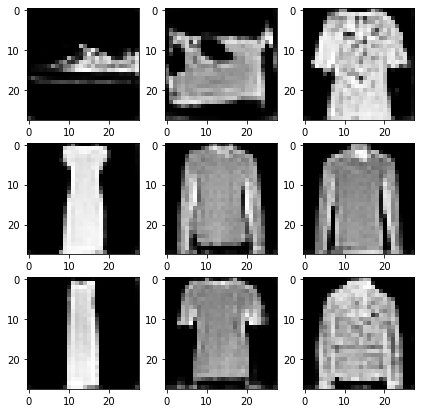

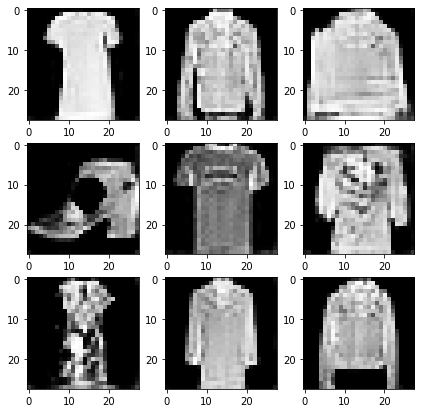

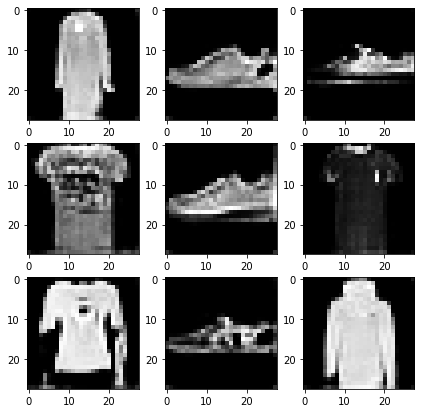

In [ ]:
#Generating Unlimited samples
for i in range(5):
    show_generator_results(generator_network)